In [1]:
# IMPORT MODULE
from fastai.vision.models.unet import DynamicUnet
from torchvision.models.resnet import resnet18
from fastai.vision.learner import create_body
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
import torch
from torch import nn, optim
from torchvision import transforms
import warnings
import imageio
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# LOAD FUNCTION

SIZE = 256
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count


def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    return {
        "loss_D_fake": loss_D_fake,
        "loss_D_real": loss_D_real,
        "loss_D": loss_D,
        "loss_G_GAN": loss_G_GAN,
        "loss_G_L1": loss_G_L1,
        "loss_G": loss_G,
    }


def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)


def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    L = (L + 1.0) * 50.0
    ab = ab * 110.0
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)


def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")


def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet18_model = resnet18(pretrained=True)  # Khởi tạo model resnet18
    body = create_body(resnet18_model, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G


class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [
            self.get_layers(
                num_filters * 2**i,
                num_filters * 2 ** (i + 1),
                s=1 if i == (n_down - 1) else 2,
            )
            for i in range(n_down)
        ]  # the 'if' statement is taking care of not using
        # stride of 2 for the last block in this loop
        # Make sure to not use normalization or
        model += [
            self.get_layers(num_filters * 2**n_down, 1, s=1, norm=False, act=False)
        ]
        # activation for the last layer of the model
        self.model = nn.Sequential(*model)

    # when needing to make some repeatitive blocks of layers,

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
        # it's always helpful to make a separate method for that purpose
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]
        if norm:
            layers += [nn.BatchNorm2d(nf)]
        if act:
            layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class GANLoss(nn.Module):
    def __init__(self, gan_mode="vanilla", real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer("real_label", torch.tensor(real_label))
        self.register_buffer("fake_label", torch.tensor(fake_label))
        if gan_mode == "vanilla":
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == "lsgan":
            self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss


def init_weights(net, init="norm", gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, "weight") and "Conv" in classname:
            if init == "norm":
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == "xavier":
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == "kaiming":
                nn.init.kaiming_normal_(m.weight.data, a=0, mode="fan_in")
            if hasattr(m, "bias") and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif "BatchNorm2d" in classname:
            nn.init.normal_(m.weight.data, 1.0, gain)
            nn.init.constant_(m.bias.data, 0.0)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net


def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model


class MainModel(nn.Module):
    def __init__(
        self, net_G, lr_G=2e-4, lr_D=2e-4, beta1=0.5, beta2=0.999, lambda_L1=100.0
    ):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        self.net_G = net_G.to(self.device)
        self.net_D = init_model(
            PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device
        )
        self.GANcriterion = GANLoss(gan_mode="vanilla").to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data["L"].to(self.device)
        self.ab = data["ab"].to(self.device)

    def forward(self):
        self.fake_color = self.net_G(self.L)

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()


def visualize(save=True, **images):
    n = len(images)
    plt.figure(figsize=(12, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())
        plt.imshow(image)

    if save:
        plt.savefig(f"output.png")
    plt.show()


def prep_data(path=None, img=None):
    _transforms = transforms.Resize((SIZE, SIZE), Image.BICUBIC)
    if path is not None:
        img = Image.open(path).convert("RGB")
    shape = img.shape[:2]
    img = _transforms(img)
    img = np.array(img)
    img_lab = rgb2lab(img).astype("float32")  # Converting RGB to L*a*b
    img_lab = transforms.ToTensor()(img_lab)
    L = img_lab[[0], ...] / 50.0 - 1.0  # Between -1 and 1
    ab = img_lab[[1, 2], ...] / 110.0  # Between -1 and 1
    return {"L": L[None, :], "ab": ab[None, :]}, (shape[1], shape[0])


def predict(model, data):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    return fake_imgs, real_imgs


def load_video(model, input_loc):
    frames = []
    cap = cv2.VideoCapture(input_loc)
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    print("Frame num: ", video_length)
    count = 0
    print("Extracting frames..\n")
    while cap.isOpened():
        ret, frame = cap.read()
        data, shape = prep_data(img=Image.fromarray(frame))
        fake_imgs, real_imgs = predict(model, data)
        frame = cv2.resize(fake_imgs[0], shape)
        frame = cv2.resize(frame, None, fx=0.4, fy=0.4)
        frames.append(frame)
        count = count + 1
        if count > (video_length - 1):
            cap.release()
            print("Completed.\n%d frame extracted." % count)
            break
    return frames


def predict_multiple_images(model, image_paths):
    fake_imgs_all = []
    real_imgs_all = []
    shapes = []

    for path in image_paths:
        data, shape = prep_data(path=path)
        fake_imgs, real_imgs = predict(model, data)
        fake_imgs_all.append(fake_imgs[0])
        real_imgs_all.append(real_imgs[0])
        shapes.append(shape)

    return fake_imgs_all, real_imgs_all, shapes


def visualize_multiple_images(fake_imgs, real_imgs, shapes):
    n = len(fake_imgs)
    plt.figure(figsize=(12, 12))  # Adjusting figure size for 3x3 grid

    for i in range(n):
        # Hiển thị ảnh gốc (real) ở phía trên (lưới 3x3)
        plt.subplot(3, 3, i + 1)
        plt.xticks([])  # Ẩn các ticks trên trục x
        plt.yticks([])  # Ẩn các ticks trên trục y
        plt.title(f"Input Image {i + 1}")
        input_im = cv2.resize(real_imgs[i], shapes[i])
        plt.imshow(input_im)

    plt.figure(figsize=(12, 12))  # New figure for colorized images
    for i in range(n):
        # Hiển thị ảnh colorized (fake) ở phía dưới (lưới 3x3)
        plt.subplot(3, 3, i + 1)
        plt.xticks([])  # Ẩn các ticks trên trục x
        plt.yticks([])  # Ẩn các ticks trên trục y
        plt.title(f"Colorized Image {i + 1}")
        output_im = cv2.resize(fake_imgs[i], shapes[i])
        plt.imshow(output_im)

    plt.tight_layout()
    plt.show()


generator_model_path = "./models/res18-unet.pt"
net_G = build_res_unet(n_input=1, n_output=2, size=256)
res_checkpoint = torch.load(generator_model_path, map_location=device)
net_G.load_state_dict(res_checkpoint["model_state_dict"])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 95.1MB/s]


FileNotFoundError: [Errno 2] No such file or directory: './models/res18-unet.pt'

In [ ]:
# LOAD MODELS
# net_G = build_res_unet(n_input=1, n_output=2, size=256)
colorization_model_path = "./models/colorization.pt"
checkpoint = torch.load(colorization_model_path, map_location=device)
model = MainModel(net_G=net_G)
model.load_state_dict(checkpoint["model_state_dict"])
model.opt_G.load_state_dict(checkpoint["optimizer_G_state_dict"])
model.opt_D.load_state_dict(checkpoint["optimizer_D_state_dict"])

model initialized with norm initialization


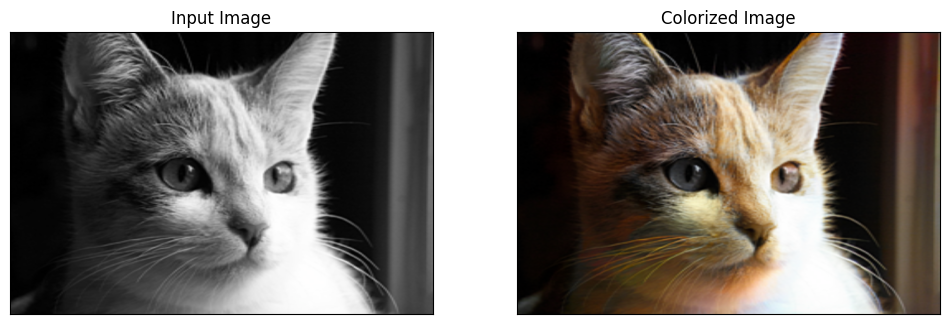

In [ ]:
data, shape = prep_data(path="./image/2.jpg")
fake_imgs, real_imgs = predict(model, data)
input_im = cv2.resize(real_imgs[0], shape)
output = cv2.resize(fake_imgs[0], shape)
visualize(input_image=input_im, colorized_image=output)

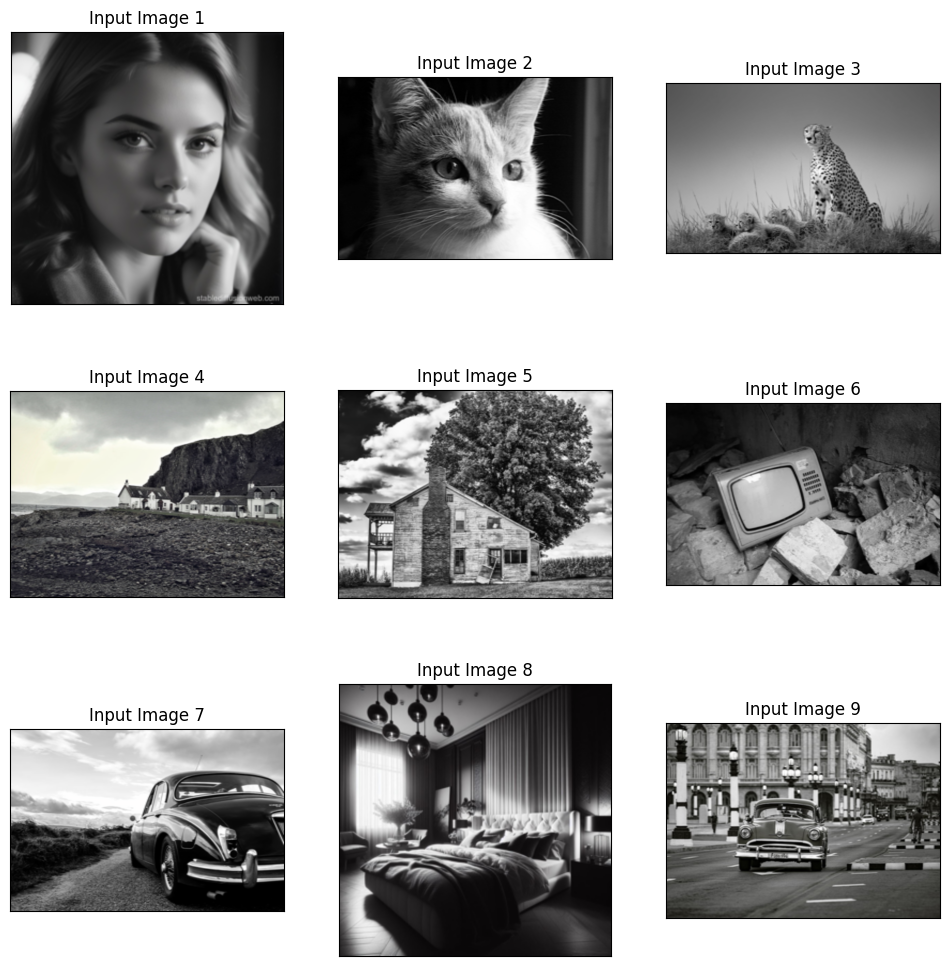

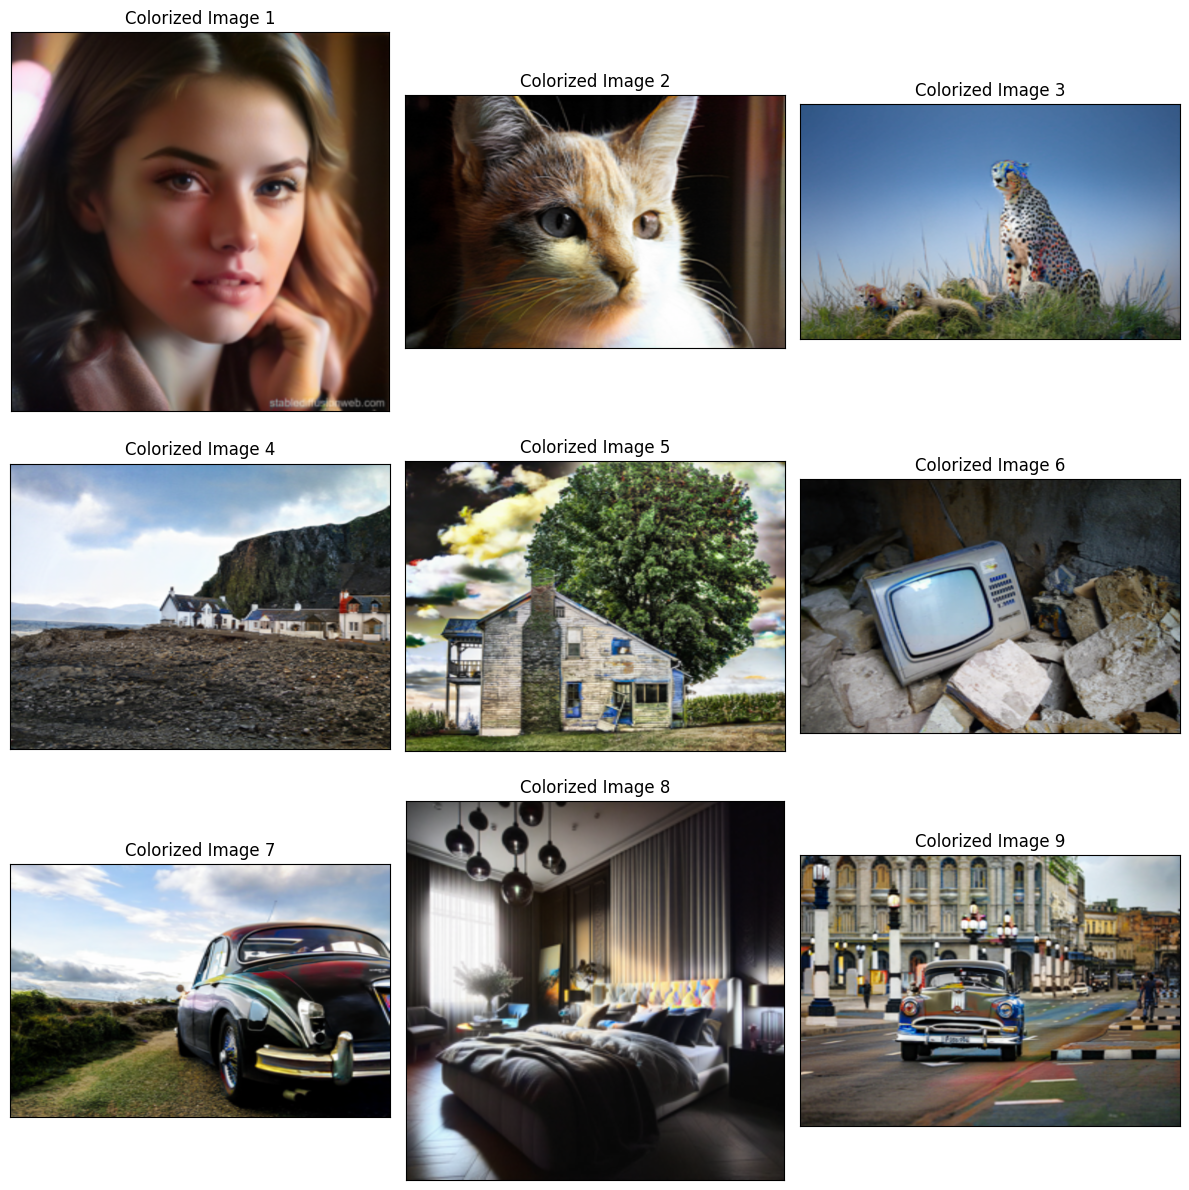

In [ ]:
image_paths = [
    "./image/1.jpg",
    "./image/2.jpg",
    "./image/3.jpg",
    "./image/4.jpg",
    "./image/5.jpg",
    "./image/6.jpg",
    "./image/7.jpg",
    "./image/8.jpg",
    "./image/9.jpg",
]

fake_imgs, real_imgs, shapes = predict_multiple_images(model, image_paths)
visualize_multiple_images(fake_imgs, real_imgs, shapes)

In [ ]:
# video_path = "./4s.mp4"
# output_path = "./colorized.gif"
# frames = load_video(video_path)
# frames_uint8 = [np.uint8(frame * 255) for frame in frames]
# imageio.mimsave(output_path, frames_uint8, format="GIF")